In [1]:
%matplotlib inline

import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
	return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

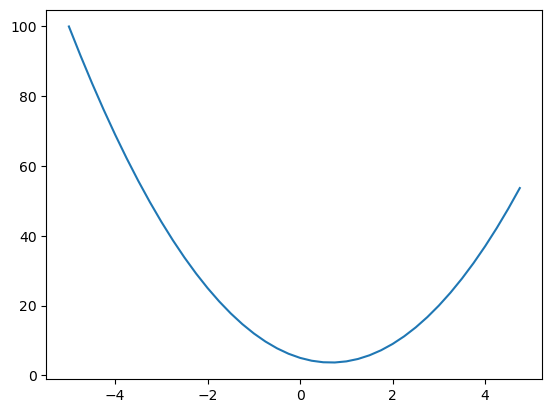

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.001
x = 3.0

delta_y = f(x+h) - f(x) # how much the function responds in the positive direction when we add `h`
delta_y

0.01400300000000243

In [6]:
# derivative (slope)
delta_y / h # normalize the rise with the run which is `h`

14.00300000000243

In [7]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a += h # what happens to result when we increase a by h ?
d2 = a*b + c

print('d1', d1)
print('d2', d2) # the new result
print('slope', (d2 - d1)/h) # similar to derivative of d wrt. a

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [9]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
b += h # what happens to result when we increase b by h ?
d2 = a*b + c

print('d1', d1)
print('d2', d2) # the new result
print('slope', (d2 - d1)/h) # similar to derivative of d wrt. b

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [10]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
c += h # what happens to result when we increase c by h ?
d2 = a*b + c

print('d1', d1)
print('d2', d2) # the new result

# similar to derivative of d wrt. c
# => the rate at which d increases as we scale c
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [50]:
# making micrograd!!

class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # default 0.0 - parameter has no effect
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # this keeps track of what operations used with children
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward

        return out
    


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L


Value(data=-8.0)

In [12]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [13]:
d._op

'+'

adding visualization code

In [14]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [15]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0

In [16]:
"""
dd / dc = 1.0
dd / de = 1.0
d = c + e

f(x + h) - f(x) / h

dL / dc = (dL / dd) * (dd / dc)
"""

c.grad = -2.0
e.grad = -2.0

In [17]:
"""
dL / de = -2.0
e = a * b

dL / da = (dL / de) * (de /da)
dL / db = (dL / de) * (de /db)
"""
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

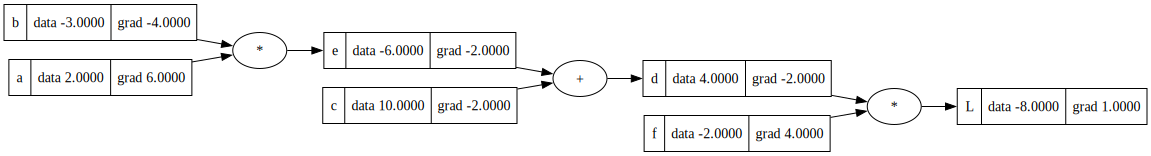

In [18]:
draw_dot(L)

In [19]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')

    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data
    
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')

    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

6.000000000021544


Let's use $\tanh$

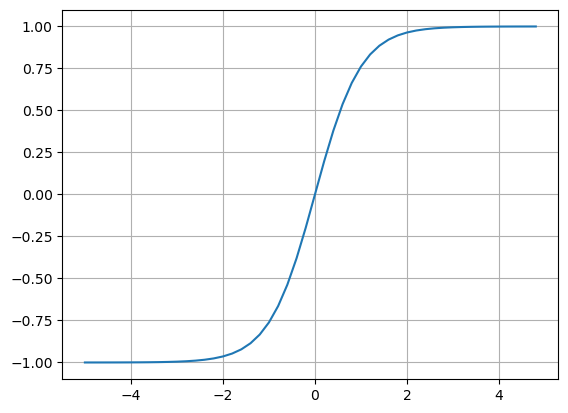

In [20]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [21]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

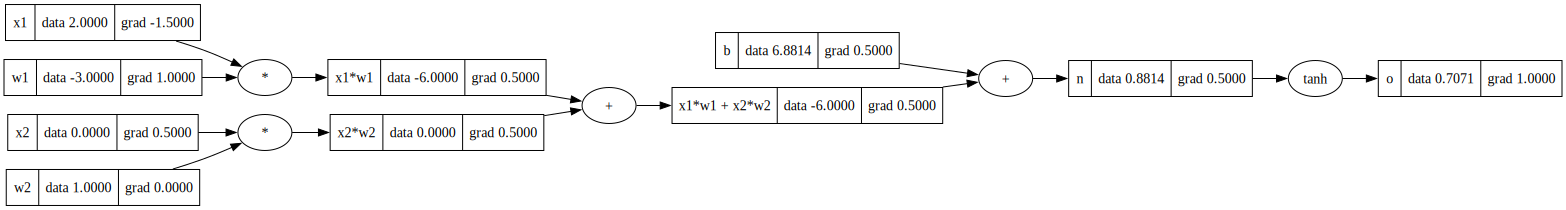

In [35]:
draw_dot(o)

Manual backprop calculation

In [24]:
## manual backprop

o.grad = 1.0

# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 - o**2 
print(1 - o.data ** 2)
n.grad = 0.5 # 1 - o.data ** 2

0.4999999999999999


In [25]:
# n = x1*w2 + x2*w2 + b
# dn/db = 1
# do/db = (do/dn)*(dn/db) = 0.5*1 = 0.5
b.grad = 0.5

# similarly
x1w1x2w2.grad = 0.5

In otherwords, for $+$ operations we just flow the gradient to each of children's gradient

In [28]:
# likewise for x1*w1 and x2*w2 because we are doing +
x1w1.grad = 0.5
x2w2.grad = 0.5

last layer!!

In [34]:
# x2*w2 = x2*w2
# d(x2*w2)/dx2 = w2
# do/dx2 = (do/d(x2*w2))*(d(x2*w2)/dx2) = 0.5*w2
x2.grad = x2w2.grad * w2.data

w2.grad = x2w2.grad * x2.data
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

# Automatic Backpropagation

In [58]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

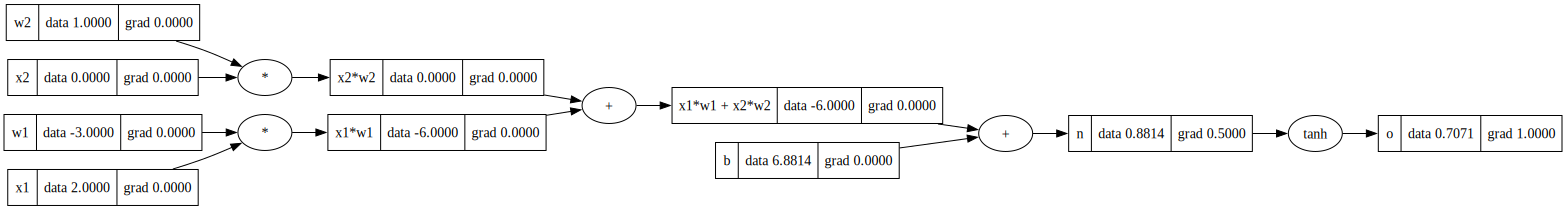

In [59]:
o.grad = 1.0
o._backward()
draw_dot(o)

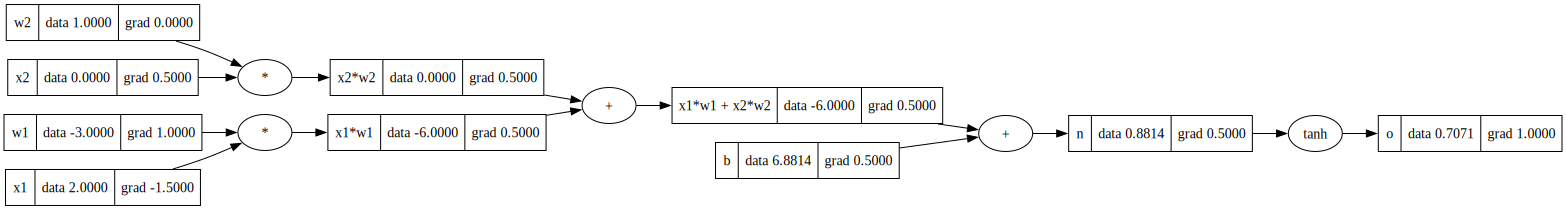

In [60]:
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)

## Topological sort
We need to get all the dependencies for our output before we can calculate it. This ordering of the graph can be accomplished with topological sort (such that the graph representation is can be viewed from left to right with directed edges only pointing nodes on the right)

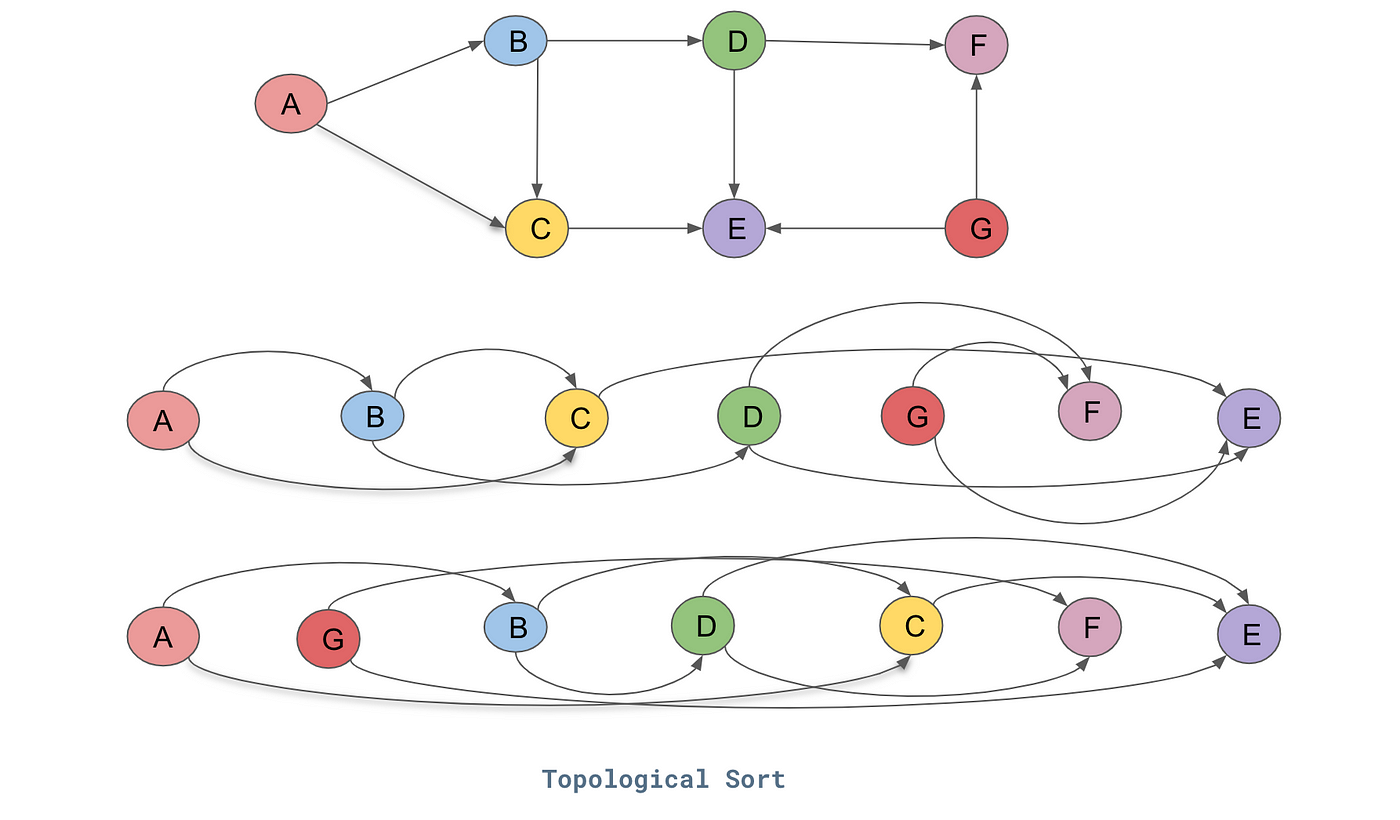

In [61]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

## The full automated pipeline

In [64]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [65]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
  node._backward()

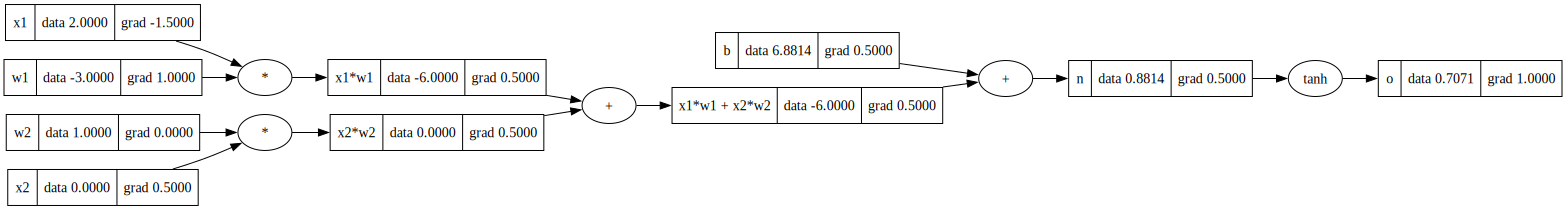

In [66]:
draw_dot(o)

# Micrograd Value class with backward

In [76]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # default 0.0 - parameter has no effect
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # this keeps track of what operations used with children
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [73]:
# now we can just do
# o.backward()

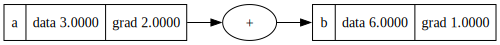

In [77]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

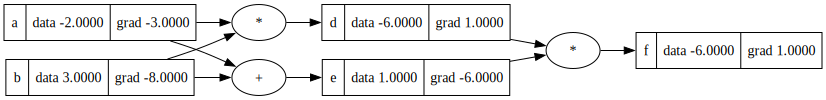

In [78]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)